## config

In [13]:
#!/usr/bin/env python3
import numpy as np
import cv2
import torch
import os
import matplotlib.pyplot as plt
from visualDet3D.utils.utils import  draw_3D_box

In [2]:
pwd

'/home/chirathv97/FYP/Stereo-Vision-Based-Vehicle-Forward-Collision-Warning-System'

In [43]:
#camera callibaration data of kitti
P2_0 = np.array([[ 7.215377000000e+02, 0.000000000000e+00, 6.095593000000e+02, 4.485728000000e+01,],
                 [0.000000000000e+00, 7.215377000000e+02, 1.728540000000e+02, 2.163791000000e-01,],
                 [0.000000000000e+00, 0.000000000000e+00, 1.000000000000e+00, 2.745884000000e-03],])
                
P3_0 = np.array([[ 7.215377000000e+02, 0.000000000000e+00, 6.095593000000e+02, -3.395242000000e+02,],
                 [ 0.000000000000e+00, 7.215377000000e+02, 1.728540000000e+02, 2.199936000000e+00,],
                 [ 0.000000000000e+00, 0.000000000000e+00, 1.000000000000e+00, 2.729905000000e-03],])

In [3]:
# #camera callibaration data of CARLA

# P2_0 = np.array([[2.849402008100e+02, 0.000000000000e+00, 1.777973651900e+02, 0.000000000000e+00,],
#  [0.000000000000e+00, 2.849402008100e+02, 1.344622583400e+02, 0.000000000000e+00,],
#  [0.000000000000e+00, 0.000000000000e+00, 1.000000000000e+00, 0.000000000000e+00],])


# P3_0 = np.array([[ 2.84940201e+02,  0.00000000e+00,  1.77797365e+02, -1.47113186e+04],
#  [ 0.00000000e+00,  2.84940201e+02,  1.34462258e+02,  0.00000000e+00],
#  [ 0.00000000e+00,  0.00000000e+00,  1.00000000e+00,  0.00000000e+00],])

In [57]:
# #camera callibaration data of LOCAL
# P2_0 = np.array([[2.849402008100e+02, 0.000000000000e+00, 1.777973651900e+02, 0.000000000000e+00,],
#                  [0.000000000000e+00, 2.849402008100e+02, 1.344622583400e+02, 0.000000000000e+00,],
#                  [0.000000000000e+00, 0.000000000000e+00, 1.000000000000e+00, 0.000000000000e+00],]) 

# P3_0 = np.array([[2.849402008100e+02, 0.000000000000e+00, 1.777973650000e+02, -1.471131860000e+04,],
#                  [0.000000000000e+00, 2.849402010000e+02, 1.344622580000e+02, 0.000000000000e+00,],
#                  [0.000000000000e+00, 0.000000000000e+00, 1.000000000000e+00, 0.000000000000e+00],]) 

In [44]:
def collate_fn(batch):
    left_images = np.array([item["image"][0] for item in batch])#[batch, H, W, 3]
    left_images = left_images.transpose([0, 3, 1, 2])

    right_images = np.array([item["image"][1] for item in batch])#[batch, H, W, 3]
    right_images = right_images.transpose([0, 3, 1, 2])  
   
    return torch.from_numpy(left_images).float(), torch.from_numpy(right_images).float()
#     return torch.from_numpy(left_images).float(), torch.from_numpy(right_images).float()

In [45]:
class Yolo3DNode:
    def __init__(self):
        print("Starting Yolo3DNode.")
        self._read_params()
        self._init_model()

    def _read_params(self):
        print("Reading params.")
        from visualDet3D.utils.utils import cfg_from_file
        from visualDet3D.networks.utils import BBox3dProjector, BackProjection

        self.cfg = cfg_from_file("config/config.py")
        self.cfg.detector.backbone.pretrained=False

        checkpoint_name = "Stereo3D_latest.pth"
        self.weight_path = os.path.join(self.cfg.path.checkpoint_path, checkpoint_name)

        self.inference_w   = 1280 #int(rospy.get_param("~INFERENCE_W",  1280))
        self.inference_h   = 288 #int(rospy.get_param("~INFERENCE_H",  288))
        self.crop_top      = 100 #int(rospy.get_param("~CROP_TOP", 100))
        self.inference_scale = 1.0 #float(rospy.get_param("~INFERENCE_SCALE", 1.0))
        self.cfg.data.test_augmentation[1].keywords.crop_top_index = self.crop_top 
        self.cfg.data.test_augmentation[2].keywords.size = (self.inference_h, self.inference_w)
        
        self.P2 = P2_0
        self.P3 = P3_0

        # Load projector and backprojector
        self.projector = BBox3dProjector().cuda()
        self.backprojector = BackProjection().cuda()

    def _init_model(self):
        print("Loading model.")
        from visualDet3D.networks.utils.registry import DETECTOR_DICT, PIPELINE_DICT
        from visualDet3D.data.pipeline import build_augmentator

         # Build a detector network
        detector = DETECTOR_DICT[self.cfg.detector.name](self.cfg.detector)
        self.detector = detector.cuda()
        # Tensor load by GPU
        state_dict = torch.load(
            self.weight_path, map_location='cuda:{}'.format(self.cfg.trainer.gpu)
        )
        self.detector.load_state_dict(state_dict, strict=False)
        self.detector.eval()
        
        # self.ort_session = ort.InferenceSession(self.onnx_path)

        self.transform = build_augmentator(self.cfg.data.test_augmentation)
        self.test_func = PIPELINE_DICT[self.cfg.trainer.test_func]
        print("Done loading model.")

    def denorm(self,image):
        new_image = np.array((image * self.cfg.data.augmentation.rgb_std +  self.cfg.data.augmentation.rgb_mean) * 255, dtype=np.uint8)
        return new_image
    
    def predict(self, left_image, right_image):
        transformed_left_image, transformed_P2 = self.transform(left_image.copy(), p2=self.P2.copy())
        transformed_right_image, transformed_P3 = self.transform(right_image.copy(), p3=self.P3.copy())
        data = {'image': [transformed_left_image,transformed_right_image]}
        data = collate_fn([data])
#         data = data + (transformed_P2, transformed_P3)
#         print('data',data)
         
        with torch.no_grad():
            left_images, right_images = data[0], data[1]
            
            transformed_P2=[transformed_P2]
            transformed_P3=[transformed_P3]
            transformed_P2=torch.tensor(transformed_P2).float()
            transformed_P3=torch.tensor(transformed_P3).float()
            scores, bbox, obj_names = self.detector([left_images.cuda().float().contiguous(),
                                          right_images.cuda().float().contiguous(),
                                          transformed_P2.cuda().float(),
                                          transformed_P3.cuda().float()])
#             scores, bbox, obj_names = self.test_func(data, self.detector, None, cfg=self.cfg)
            transformed_P2 = transformed_P2[0]
            bbox_2d = bbox[:, 0:4]
            bbox_3d_state = bbox[:, 4:] #[cx,cy,z,w,h,l,alpha]
            bbox_3d_state[:, 2] *= self.inference_scale
            bbox_3d_state_3d = self.backprojector(bbox_3d_state, transformed_P2.cuda()) #[x, y, z, w,h ,l, alpha]
#             abs_bbox, bbox_3d_corner_homo, thetas = self.projector(bbox_3d_state_3d, bbox_3d_state_3d.new(transformed_P2))
            abs_bbox, bbox_3d_corner_homo, thetas = self.projector(bbox_3d_state_3d, transformed_P2.cuda())
        
#             rgb_image = self.denorm(left_images[0].transpose([1, 2, 0]))
            rgb_image = self.denorm(left_images[0].cpu().numpy().transpose([1, 2, 0]))
        
            return rgb_image, scores, bbox_2d, obj_names, bbox_3d_corner_homo
    

In [46]:
#detection model
detector = Yolo3DNode()

Starting Yolo3DNode.
Reading params.
Loading model.
Done loading model.


## try for 1 image pair

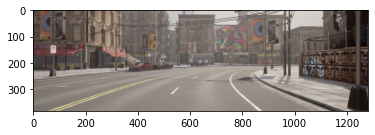

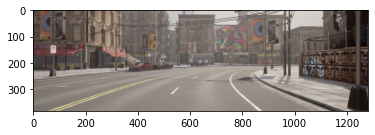

In [47]:
left_image = cv2.imread("data/carla_s1_left/000000.png")
img2 = left_image[:,:,::-1]
plt.imshow(img2)
plt.show()

right_image = cv2.imread("data/carla_s1_right/000000.png")
img2 = left_image[:,:,::-1]
plt.imshow(img2)
plt.show()

In [48]:
data = detector.predict(left_image, right_image)
rgb_image, scores, bbox_2d, obj_names, bbox_3d_corner_homo = data

/home/chirathv97/FYP/Stereo-Vision-Based-Vehicle-Forward-Collision-Warning-System/visualDet3D/networks/lib/PSM_cost_volume.py:87: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  volatile= not self.training
/home/chirathv97/FYP/Stereo-Vision-Based-Vehicle-Forward-Collision-Warning-System/visualDet3D/networks/lib/PSM_cost_volume.py:55: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  volatile= not self.training


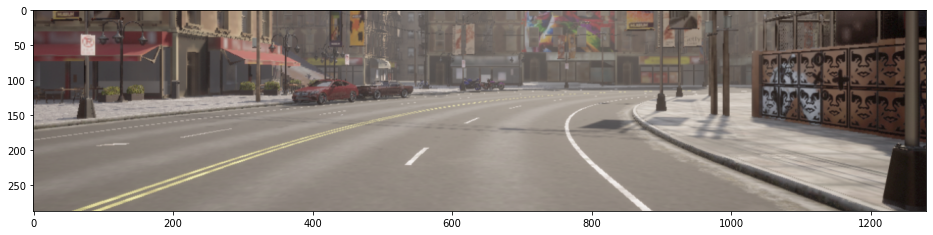

In [49]:
if len(scores) > 0:
#         rgb_image = draw_bbox2d_to_image(rgb_image, bbox_2d.cpu().numpy())
        for box in bbox_3d_corner_homo:
            box = box.cpu().numpy().T
            rgb_image = draw_3D_box(rgb_image, box)
fig = plt.figure(figsize=(16,9))
rgb_image = rgb_image[:,:,::-1]
plt.imshow(np.clip(rgb_image, 0, 255))

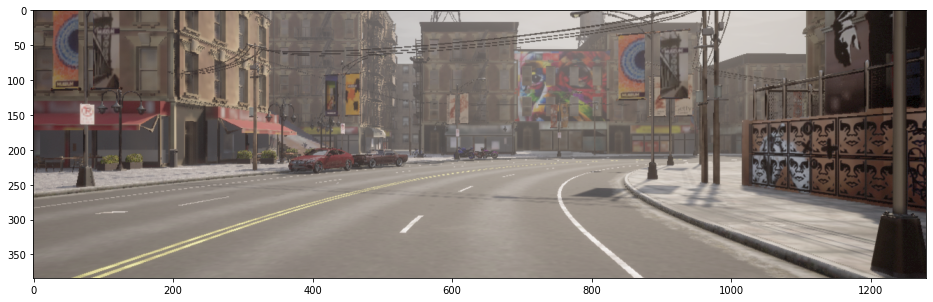

In [50]:
li=left_image.copy()

fig = plt.figure(figsize=(16,9))
for box in bbox_3d_corner_homo:
    box = box.cpu().numpy().T
    rgb_image = draw_3D_box(li, box)
li = li[:,:,::-1]
plt.imshow(li)

## try for image sequence

In [51]:
from IPython.display import clear_output
import time

9


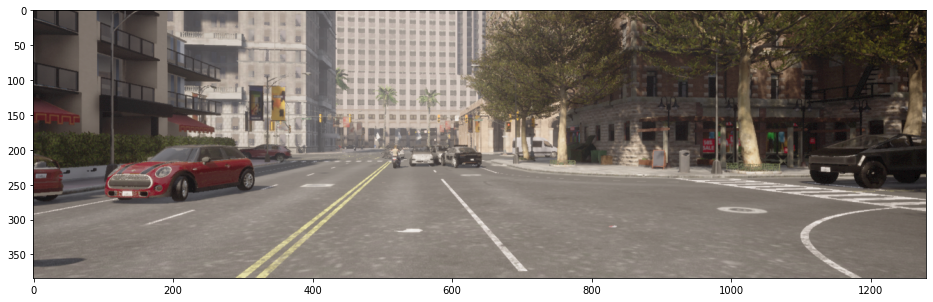

In [52]:
for i in range (10):
    left_image = cv2.imread("data/carla_s2_left/%06d" % i+".png")
    right_image = cv2.imread("data/carla_s2_right/%06d" % i+".png")
    img2 = left_image[:,:,::-1]
    
    fig = plt.figure(figsize=(16,9))
    clear_output(wait=True) #to show in same window 
    print(i)
    plt.imshow(img2)
    plt.show()

89


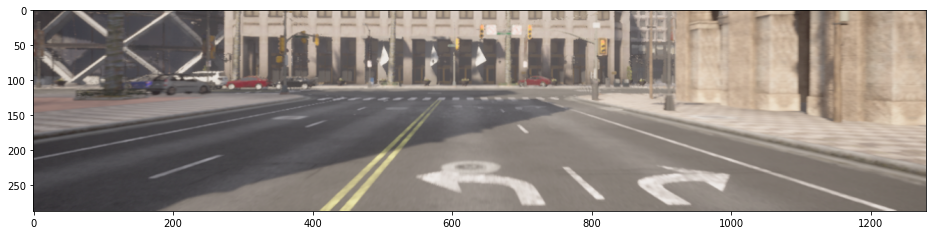

KeyboardInterrupt: 

In [68]:
start_track = time.time()

l=100
for i in range (400):
    left_image = cv2.imread("data/carla_s2_left/%06d" % i+".png")
    right_image = cv2.imread("data/carla_s2_right/%06d" % i+".png")
    
    rgb_image, scores, bbox_2d, obj_names, bbox_3d_corner_homo = detector.predict(left_image, right_image)
    
    fig = plt.figure(figsize=(16,9))
    for box in bbox_3d_corner_homo:
        box = box.cpu().numpy().T
        rgb_image = draw_3D_box(rgb_image, box)
    rgb_image=cv2.cvtColor(rgb_image, cv2.COLOR_BGR2RGB)
    clear_output(wait=True) #to show in same window 
    plt.imshow(rgb_image)
    print(i)
    plt.show()
    
end_track = time.time()

# Time elapsed
seconds_track = end_track - start_track
print ("Time taken : {0} seconds".format(seconds_track))

# Calculate frames per second
fps_track  = l / seconds_track
print("Estimated frames per second : {0}".format(fps_track))

## tracking + trajectory

In [54]:
import numpy as np
import collections

from filterpy.kalman import KalmanFilter

def linear_assignment(cost_matrix):
    try:
        import lap
        _, x, y = lap.lapjv(cost_matrix, extend_cost=True)
        return np.array([[y[i],i] for i in x if i >= 0]) #
    except ImportError:
        from scipy.optimize import linear_sum_assignment
        x, y = linear_sum_assignment(cost_matrix)
        return np.array(list(zip(x, y)))

def iou_batch(bb_test, bb_gt):
    """
    From SORT: Computes IOU between two bboxes in the form [x1,y1,x2,y2]
    """
    bb_gt = np.expand_dims(bb_gt, 0)
    bb_test = np.expand_dims(bb_test, 1)

    xx1 = np.maximum(bb_test[..., 0], bb_gt[..., 0])
    yy1 = np.maximum(bb_test[..., 1], bb_gt[..., 1])
    xx2 = np.minimum(bb_test[..., 2], bb_gt[..., 2])
    yy2 = np.minimum(bb_test[..., 3], bb_gt[..., 3])
    w = np.maximum(0., xx2 - xx1)
    h = np.maximum(0., yy2 - yy1)
    wh = w * h
    o = wh / ((bb_test[..., 2] - bb_test[..., 0]) * (bb_test[..., 3] - bb_test[..., 1])                                      
    + (bb_gt[..., 2] - bb_gt[..., 0]) * (bb_gt[..., 3] - bb_gt[..., 1]) - wh)                                              
    return(o)  


def convert_bbox_to_z(bbox):
    """
    Takes a bounding box in the form [x1,y1,x2,y2] and returns z in the form
    [x,y,s,r] where x,y is the centre of the box and s is the scale/area and r is
    the aspect ratio
    """
    w = bbox[2] - bbox[0]
    h = bbox[3] - bbox[1]
    x = bbox[0] + w/2.
    y = bbox[1] + h/2.
    s = w * h    #scale is just area
    r = w / float(h)
    return np.array([x, y, s, r]).reshape((4, 1))

def convert_x_to_bbox(x,score=None):
    """
    Takes a bounding box in the centre form [x,y,s,r] and returns it in the form
    [x1,y1,x2,y2] where x1,y1 is the top left and x2,y2 is the bottom right
    """
    w = np.sqrt(x[2] * x[3])
    h = x[2] / w
    if(score==None):
        return np.array([x[0]-w/2.,x[1]-h/2.,x[0]+w/2.,x[1]+h/2.]).reshape((1,4))
    else:
        return np.array([x[0]-w/2.,x[1]-h/2.,x[0]+w/2.,x[1]+h/2.,score]).reshape((1,5))

def associate_detections_to_trackers(detections,trackers,iou_threshold = 0.3):
    """
    Assigns detections to tracked object (both represented as bounding boxes)

    Returns 3 lists of matches, unmatched_detections and unmatched_trackers
    """
    if(len(trackers)==0):
        return np.empty((0,2),dtype=int), np.arange(len(detections)), np.empty((0,5),dtype=int)

    iou_matrix = iou_batch(detections, trackers)

    if min(iou_matrix.shape) > 0:
        a = (iou_matrix > iou_threshold).astype(np.int32)
        if a.sum(1).max() == 1 and a.sum(0).max() == 1:
            matched_indices = np.stack(np.where(a), axis=1)
        else:
            matched_indices = linear_assignment(-iou_matrix)
    else:
        matched_indices = np.empty(shape=(0,2))

    unmatched_detections = []
    for d, det in enumerate(detections):
        if(d not in matched_indices[:,0]):
            unmatched_detections.append(d)
    unmatched_trackers = []
    for t, trk in enumerate(trackers):
        if(t not in matched_indices[:,1]):
            unmatched_trackers.append(t)

    #filter out matched with low IOU
    matches = []
    for m in matched_indices:
        if(iou_matrix[m[0], m[1]]<iou_threshold):
            unmatched_detections.append(m[0])
            unmatched_trackers.append(m[1])
        else:
            matches.append(m.reshape(1,2))
    if(len(matches)==0):
        matches = np.empty((0,2),dtype=int)
    else:
        matches = np.concatenate(matches,axis=0)

    return matches, np.array(unmatched_detections), np.array(unmatched_trackers)

In [55]:
class KalmanBoxTracker(object):
    """
    This class represents the internal state of individual tracked objects observed as bbox.
    """
    count = 0
    def __init__(self,bbox,no_of_past_frames=5,no_of_future_frames=5):
        """
        Initialises a tracker using initial bounding box.
        """
        #define constant velocity model
        self.kf = KalmanFilter(dim_x=7, dim_z=4) 
        self.kf.F = np.array([[1,0,0,0,1,0,0],[0,1,0,0,0,1,0],[0,0,1,0,0,0,1],[0,0,0,1,0,0,0],  [0,0,0,0,1,0,0],[0,0,0,0,0,1,0],[0,0,0,0,0,0,1]])
        self.kf.H = np.array([[1,0,0,0,0,0,0],[0,1,0,0,0,0,0],[0,0,1,0,0,0,0],[0,0,0,1,0,0,0]])

        self.kf.R[2:,2:] *= 10.
        self.kf.P[4:,4:] *= 1000. #give high uncertainty to the unobservable initial velocities
        self.kf.P *= 10.
        self.kf.Q[-1,-1] *= 0.01
        self.kf.Q[4:,4:] *= 0.01

        self.kf.x[:4] = convert_bbox_to_z(bbox)
        self.time_since_update = 0
        self.id = KalmanBoxTracker.count
        KalmanBoxTracker.count += 1
        self.history = []

        self.no_of_past_frames = no_of_past_frames
        self.no_of_future_frames = no_of_future_frames
        self.update_history = collections.deque(maxlen=self.no_of_past_frames)
        self.predict_history = collections.deque(maxlen=self.no_of_future_frames)

        self.hits = 0
        self.hit_streak = 0
        self.age = 0

    def update(self,bbox):
        """
        Updates the state vector with observed bbox.
        """
        self.time_since_update = 0
        self.history = []
        self.hits += 1
        self.hit_streak += 1
        self.kf.update(convert_bbox_to_z(bbox))
        self.update_history.append(bbox)

        if  len(self.update_history)>=self.no_of_past_frames :
            kbt = KalmanBoxTrajectory(self.update_history[0])
            for j in range(1,self.no_of_past_frames):
                kbt.predict()
                p = kbt.update(self.update_history[j])
            for k in range(self.no_of_future_frames):
                p = kbt.predict()[0]
                self.predict_history.append(p)


    def predict(self):
        """
        Advances the state vector and returns the predicted bounding box estimate.
        """
        if((self.kf.x[6]+self.kf.x[2])<=0):
          self.kf.x[6] *= 0.0
        self.kf.predict()
        self.age += 1
        if(self.time_since_update>0):
          self.hit_streak = 0
        self.time_since_update += 1
        self.history.append(convert_x_to_bbox(self.kf.x))
        return self.history[-1]

    def get_state(self):
        """
        Returns the current bounding box estimate.
        """
        return convert_x_to_bbox(self.kf.x)

    def get_future_predictions(self):
        """
        Returns the future bounding box estimate.
        """
        return np.array(self.predict_history)
    
class KalmanBoxTrajectory(object):
  """
  This class represents the internal state of individual tracked objects observed as bbox.
  """
  count = 0
  def __init__(self,bbox):
    """
    Initialises a tracker using initial bounding box.
    """
    #define constant velocity model
    self.kf = KalmanFilter(dim_x=7, dim_z=4) 
    self.kf.F = np.array([[1,0,0,0,1,0,0],[0,1,0,0,0,1,0],[0,0,1,0,0,0,1],[0,0,0,1,0,0,0],  [0,0,0,0,1,0,0],[0,0,0,0,0,1,0],[0,0,0,0,0,0,1]])
    self.kf.H = np.array([[1,0,0,0,0,0,0],[0,1,0,0,0,0,0],[0,0,1,0,0,0,0],[0,0,0,1,0,0,0]])

    self.kf.R[2:,2:] *= 10.
    self.kf.P[4:,4:] *= 1000. #give high uncertainty to the unobservable initial velocities
    self.kf.P *= 10.
    self.kf.Q[-1,-1] *= 0.01
    self.kf.Q[4:,4:] *= 0.01

    self.kf.x[:4] = convert_bbox_to_z(bbox)
    self.id = KalmanBoxTrajectory.count
    KalmanBoxTrajectory.count += 1
    self.history = []

  def update(self,bbox):
    """
    Updates the state vector with observed bbox.
    """
    self.history = []
    self.kf.update(convert_bbox_to_z(bbox))    

  def predict(self):
    """
    Advances the state vector and returns the predicted bounding box estimate.
    """
    if((self.kf.x[6]+self.kf.x[2])<=0):
      self.kf.x[6] *= 0.0
    self.kf.predict()
    self.history.append(convert_x_to_bbox(self.kf.x))
    return self.history[-1]

  def get_state(self):
    """
    Returns the current bounding box estimate.
    """
    return convert_x_to_bbox(self.kf.x)
class KalmanBoxTrajectory(object):
  """
  This class represents the internal state of individual tracked objects observed as bbox.
  """
  count = 0
  def __init__(self,bbox):
    """
    Initialises a tracker using initial bounding box.
    """
    #define constant velocity model
    self.kf = KalmanFilter(dim_x=7, dim_z=4) 
    self.kf.F = np.array([[1,0,0,0,1,0,0],[0,1,0,0,0,1,0],[0,0,1,0,0,0,1],[0,0,0,1,0,0,0],  [0,0,0,0,1,0,0],[0,0,0,0,0,1,0],[0,0,0,0,0,0,1]])
    self.kf.H = np.array([[1,0,0,0,0,0,0],[0,1,0,0,0,0,0],[0,0,1,0,0,0,0],[0,0,0,1,0,0,0]])

    self.kf.R[2:,2:] *= 10.
    self.kf.P[4:,4:] *= 1000. #give high uncertainty to the unobservable initial velocities
    self.kf.P *= 10.
    self.kf.Q[-1,-1] *= 0.01
    self.kf.Q[4:,4:] *= 0.01

    self.kf.x[:4] = convert_bbox_to_z(bbox)
    self.id = KalmanBoxTrajectory.count
    KalmanBoxTrajectory.count += 1
    self.history = []

  def update(self,bbox):
    """
    Updates the state vector with observed bbox.
    """
    self.history = []
    self.kf.update(convert_bbox_to_z(bbox))    

  def predict(self):
    """
    Advances the state vector and returns the predicted bounding box estimate.
    """
    if((self.kf.x[6]+self.kf.x[2])<=0):
      self.kf.x[6] *= 0.0
    self.kf.predict()
    self.history.append(convert_x_to_bbox(self.kf.x))
    return self.history[-1]

  def get_state(self):
    """
    Returns the current bounding box estimate.
    """
    return convert_x_to_bbox(self.kf.x)

In [56]:
#trajectory class
class Trajectory(object):
  def __init__(self, max_age=1, min_hits=3, iou_threshold=0.3, no_of_future_frames=5, no_of_past_frames=5):
    """
    Sets key parameters for Trajectory
    """
    self.max_age = max_age
    self.min_hits = min_hits
    self.iou_threshold = iou_threshold
    self.trackers = []
    self.frame_count = 0

    self.no_of_future_frames = no_of_future_frames
    self.no_of_past_frames = no_of_past_frames


  def update(self, dets=np.empty((0, 5))):
    """
    Params:
      dets - a numpy array of detections in the format [[x1,y1,x2,y2,score],[x1,y1,x2,y2,score],...]
    Requires: this method must be called once for each frame even with empty detections (use np.empty((0, 5)) for frames without detections).
    Returns the a similar array, where the last column is the object ID.

    NOTE: The number of objects returned may differ from the number of detections provided.
    """
    self.frame_count += 1
    # get predicted locations from existing trackers.
    trks = np.zeros((len(self.trackers), 5))
    to_del = []
    ret = []
    for t, trk in enumerate(trks):
      pos = self.trackers[t].predict()[0]
      trk[:] = [pos[0], pos[1], pos[2], pos[3], 0]
      if np.any(np.isnan(pos)):
        to_del.append(t)
    trks = np.ma.compress_rows(np.ma.masked_invalid(trks))
    for t in reversed(to_del):
      self.trackers.pop(t)
    matched, unmatched_dets, unmatched_trks = associate_detections_to_trackers(dets,trks, self.iou_threshold)

    # update matched trackers with assigned detections
    for m in matched:
      self.trackers[m[1]].update(dets[m[0], :])

    # create and initialise new trackers for unmatched detections
    for i in unmatched_dets:
        trk = KalmanBoxTracker(dets[i,:],self.no_of_past_frames,self.no_of_future_frames)
        self.trackers.append(trk)
    i = len(self.trackers)
    for trk in reversed(self.trackers):
        d = trk.get_state()[0] #current bounding box position
        fp = trk.get_future_predictions() #future predictions
        if (trk.time_since_update < 1) and (trk.hit_streak >= self.min_hits or self.frame_count <= self.min_hits):
          ret.append([d,fp, trk.id]) 
        i -= 1
        # remove dead tracklet
        if(trk.time_since_update > self.max_age):
          self.trackers.pop(i)
    if(len(ret)>0):
      return np.array(ret)
    return np.empty((0,5))

In [78]:
#create instance of Trajectory
mot_tracker = Trajectory() 

In [70]:
def assignTrackID(left_image,right_image):
    # get detections
    rgb_image, scores, bbox_2d, obj_names, bbox_3d_corner_homo = detector.predict(left_image, right_image)
    
    if len(scores) > 0:
        
        """
            NOTE: In 3D bbox_3d_corner_homo 0,1,2,7 are the coordinates of the front face of the 3D bounding box
        """
        
        
        detectionsList=[]
        for i in range(len(scores)):
            #for 2d bounding box
#             detection=np.append((bbox_2d[i]).cpu(),scores[i].cpu())
            
            #for 3D bounding box converting to 2D
            coords_3d = bbox_3d_corner_homo[i].cpu()
            x1,y1 = coords_3d[1][0], coords_3d[1][1]
            x2,y2 = coords_3d[7][0], coords_3d[7][1]
            bb=[x1,y1,x2,y2]
            detection=np.append(bb,scores[i].cpu())
            
            detectionsList.append(detection)
        detectionsNumPyArray = np.asarray(detectionsList)
#         print('-------detectionsNumPyArray-------\n',detectionsNumPyArray)
#         print('-------type detectionsNumPyArray-------\n',type(detectionsNumPyArray))
#         print('-------detectionsNumPyArray 0-------\n',detectionsNumPyArray[0])
        # update SORT
        #  def update(self, dets=np.empty((0, 5))):
        """
            Params:
              dets - a numpy array of detections in the format [[x1,y1,x2,y2,score],[x1,y1,x2,y2,score],...]
            Requires: this method must be called once for each frame even with empty detections (use np.empty((0, 5)) for frames without detections).
            Returns the a similar array, where the last column is the object ID.

            NOTE: The number of objects returned may differ from the number of detections provided.
        """
        track_bbs_ids_list = mot_tracker.update(detectionsNumPyArray)
#         print('-------track_bbs_ids_list-------\n',track_bbs_ids_list)
    # track_bbs_ids is a np array where each row contains a valid bounding box and track_id (last column)

        for box in bbox_3d_corner_homo:
            box = box.cpu().numpy().T
            rgb_image = draw_3D_box(rgb_image, box)

        track_bbs_ids_list=track_bbs_ids_list.tolist()
        
        for track_bbs_ids in track_bbs_ids_list:
            coords = track_bbs_ids[0]
            x1,y1,x2,y2=int(coords[0]),int(coords[1]),int(coords[2]),int(coords[3])
            trackID=int(track_bbs_ids[-1])
            name="ID: {}".format(str(trackID))

            # font
            font = cv2.FONT_HERSHEY_SIMPLEX
            # org
            org = (x1, y1-10)
            # fontScale
            fontScale = 0.9
            # Line thickness of 2 px
            thickness = 2
            # Blue color in BGR
            color=(0, 255, 255)
            text_color_bg=(0, 0, 0)
            text_size, _ = cv2.getTextSize(name, font, fontScale, thickness)
            text_w, text_h = text_size
            cv2.rectangle(rgb_image, (x1 , y1-10 - text_h), (x1 + text_w, y1-10), text_color_bg, -1)
            
            # Using cv2.putText() method
            cv2.putText(rgb_image,name, org, font, fontScale, color, thickness, cv2.LINE_AA)

                
# def draw_bbox2d_to_image(image, bboxes2d, color=(255, 0, 255)):
#     drawed_image = image.copy()
#     for box2d in bboxes2d:
#         cv2.rectangle(drawed_image, (int(box2d[0]), int(box2d[1])), (int(box2d[2]), int(box2d[3])), color, 3)
#     return drawed_image
    else:
        track_bbs_ids_list = mot_tracker.update(np.empty((0, 5)))
    return np.clip(rgb_image, 0, 255), track_bbs_ids_list

### try for 1 image pair

In [71]:
left_image = cv2.imread("data/carla_s1_left/%06d" % 8+".png")
right_image = cv2.imread("data/carla_s1_right/%06d" % 8+".png")

imagei,track_bbs_ids=assignTrackID(left_image,right_image)
# print(track_bbs_ids)
for bbs in track_bbs_ids: #for each vehicle in a image frame
    bb=bbs[0] #current bounding box
    future_bb=bbs[1] #future bounding boxes
    vehicle_id=bbs[-1] #vehicle id
    print('bb coords',bb)
    print('trackID',bbs[-1])
    print('future coords',future_bb,'\n')

bb coords [544.93817141 128.19999691 557.51123045 101.22006993]
trackID 5
future coords [] 

bb coords [435.62176508 130.95617681 466.86141974 100.02130884]
trackID 4
future coords [] 



/home/chirathv97/FYP/Stereo-Vision-Based-Vehicle-Forward-Collision-Warning-System/visualDet3D/networks/lib/PSM_cost_volume.py:87: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  volatile= not self.training
/home/chirathv97/FYP/Stereo-Vision-Based-Vehicle-Forward-Collision-Warning-System/visualDet3D/networks/lib/PSM_cost_volume.py:55: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  volatile= not self.training
/home/chirathv97/anaconda3/envs/yolo3dpy37/lib/python3.7/site-packages/ipykernel_launcher.py:60: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


In [72]:
x0_danger_zone=400#300#400
x1_danger_zone=800#900#800
y0_danger_zone=300
y1_danger_zone=200#150#200
w_danger_zone=100#150#100

x0 = x0_danger_zone
x1 = x1_danger_zone
y0 = y0_danger_zone
y1 = y1_danger_zone
w = w_danger_zone

def is_in_zone(x,y):
    if x0_danger_zone<x<x1_danger_zone and y0_danger_zone>y>y1_danger_zone:
        return True
    return False

def get_zone_check_point(bb):
    x0,y0,x1,y1=bb
    if x0<x1_danger_zone:
        x=x0
    else:
        x=x1
    y=max(y0,y1)
    return x,y
           

### try for sequance image pairs

In [73]:
start_track = time.time()
l=100

for i in range (l):
    left_image = cv2.imread("data/carla_s1_left/%06d" % i+".png")
    right_image = cv2.imread("data/carla_s1_right/%06d" % i+".png")
    
    imagei,track_bbs_ids=assignTrackID(left_image,right_image)
    print('-------------------- {} --------------------'.format(i))

    for bbs in track_bbs_ids: #for each vehicle in a image frame
        bb=bbs[0] #current bounding box
        future_bbs=bbs[1] #future bounding boxes
        vehicle_ID=bbs[-1] #vehicle id
#         print('bb coords',bb)
#         print('trackID',bbs[-1])
#         print('future coords',future_bb,'\n')
    
        x,y=get_zone_check_point(bb)
        if is_in_zone(x,y):
            print('Warning!','Frame:',frame,'vehicle ID:',i)
            
        for i,future_bb in enumerate (future_bbs):
            x,y=get_zone_check_point(future_bb)
            if is_in_zone(x,y):
                print('Warning!','Future Frame: ',i,'vehicle ID:',vehicle_ID)
                
end_track = time.time()

# Time elapsed
seconds_track = end_track - start_track
print ("Time taken : {0} seconds".format(seconds_track))

# Calculate frames per second
fps_track  = l / seconds_track
print("Estimated frames per second : {0}".format(fps_track))

/home/chirathv97/FYP/Stereo-Vision-Based-Vehicle-Forward-Collision-Warning-System/visualDet3D/networks/lib/PSM_cost_volume.py:87: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  volatile= not self.training
/home/chirathv97/FYP/Stereo-Vision-Based-Vehicle-Forward-Collision-Warning-System/visualDet3D/networks/lib/PSM_cost_volume.py:55: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  volatile= not self.training


-------------------- 0 --------------------
-------------------- 1 --------------------
-------------------- 2 --------------------
-------------------- 3 --------------------
-------------------- 4 --------------------
-------------------- 5 --------------------
-------------------- 6 --------------------
-------------------- 7 --------------------
-------------------- 8 --------------------
-------------------- 9 --------------------
-------------------- 10 --------------------
-------------------- 11 --------------------
-------------------- 12 --------------------
-------------------- 13 --------------------
-------------------- 14 --------------------
-------------------- 15 --------------------
-------------------- 16 --------------------
-------------------- 17 --------------------
-------------------- 18 --------------------
-------------------- 19 --------------------
-------------------- 20 --------------------
-------------------- 21 --------------------
--------------------

In [81]:
# results
# Time taken : 12.169893980026245 seconds
# Estimated frames per second : 8.216998452420729

#carla s1 with kitti p2 p3
# Time taken : 11.598256826400757 seconds
# Estimated frames per second : 8.621985311824883

### visualize

In [79]:
def show_zone_warning(image_c,id_list):
#     fig = plt.figure(figsize=(16,9))
#     clear_output(wait=True)
#     draw_danger_zone(image_c)

    message= "Warning! ID:"+ str(id_list)

    font = cv2.FONT_HERSHEY_SIMPLEX
    fontScale = 1
    thickness = 1
    color=(255,0,0)
    text_color_bg=(255, 255, 255)
    text_size, _ = cv2.getTextSize(message, font, fontScale, thickness)
    text_w, text_h = text_size
    x1 = int(620-text_w/2)
    y1 = 60
    cv2.rectangle(image_c, (x1 , y1-10 - text_h), (x1 + text_w, y1+10), text_color_bg, -1)
    cv2.putText(image_c,message, (x1,y1), font, fontScale, color, thickness, cv2.LINE_AA)
#     plt.imshow(image_c)
#     plt.show()


    #warning sound
    os.system("echo -n '\a';sleep 0.1;" * 5)


def show_future_warning(image_c,id_list):
#     fig = plt.figure(figsize=(16,9))
#     clear_output(wait=True)
#     draw_danger_zone(image_c)

    message= "Future Warning! ID:"+ str(id_list)

    font = cv2.FONT_HERSHEY_SIMPLEX
    fontScale = 1
    thickness = 1
    color=(255,0,0)
    text_color_bg=(255, 255, 255)
    text_size, _ = cv2.getTextSize(message, font, fontScale, thickness)
    text_w, text_h = text_size
    x1 = int(620-text_w/2)
    y1 = 30
    cv2.rectangle(image_c, (x1 , y1-text_h-10), (x1 + text_w, y1+10), text_color_bg, -1)
    cv2.putText(image_c,message, (x1,y1), font, fontScale, color, thickness, cv2.LINE_AA)
    
    #warning sound
    os.system("echo -n '\a';sleep 0.1;" * 3)
    
def draw_danger_zone(rgb_image):
    thickness=3
    color=text_color_bg=(0, 125, 255)
    pts=np.array([[x0,y0],[x0+w,y1],[x1-w,y1],[x1,y0]],np.int32)
    isClosed=True
    cv2.polylines(rgb_image, [pts],isClosed, color, thickness)
#     cv2.rectangle(rgb_image, (x0 , y0), (x1, y1), text_color_bg, 0)    


# beep = lambda x: os.system("echo -n '\a';sleep 0.2;" * x)
# beep(3)

In [80]:
os.system("echo -n '\a';sleep 0.05;" * 3)

0

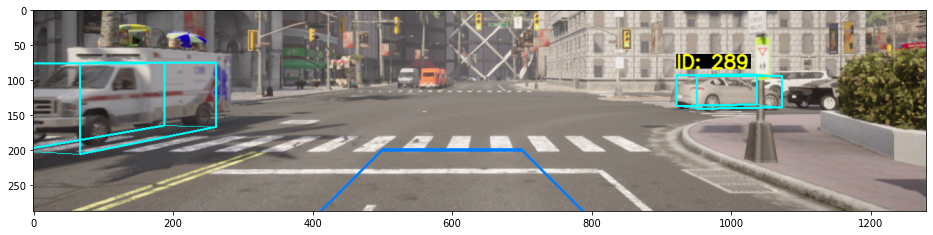

Time taken : 204.12208485603333 seconds
Estimated frames per second : 3.7624542221468493


In [77]:
start_track = time.time()
l=768

for i in range (l):
    left_image = cv2.imread("./data/carla_s1_left/%06d" % i+".png")
    right_image = cv2.imread("./data/carla_s1_right/%06d" % i+".png")
    
    image,track_bbs_ids=assignTrackID(left_image,right_image)
#     print('-------------------- {} --------------------'.format(i))
    
    id_list=[]
    future_id_list=[]

    for bbs in track_bbs_ids: #for each vehicle in a image frame
        bb=bbs[0] #current bounding box
        future_bbs=bbs[1] #future bounding boxes
        vehicle_ID=bbs[-1] #vehicle id
#         print('bb coords',bb)
#         print('trackID',bbs[-1])
#         print('future coords',future_bb,'\n')
    
        x,y=get_zone_check_point(bb)
        if is_in_zone(x,y):
            print('Warning!','Frame:',i,'vehicle ID:',i)
            id_list.append(vehicle_ID)
            
        for i,future_bb in enumerate (future_bbs):
            x,y=get_zone_check_point(future_bb)
            if is_in_zone(x,y):
                print('Warning!','Future Frame: ',i,'vehicle ID:',vehicle_ID)
                future_id_list.append(vehicle_ID)
                
    rgb_image=cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    
    draw_danger_zone(rgb_image)
    if len(id_list)>0:
        show_zone_warning(rgb_image,id_list)
    if len(future_id_list)>0:
        show_future_warning(rgb_image,future_id_list)
        
    
    fig = plt.figure(figsize=(16,9))
    clear_output(wait=True) #to show in same window 
    plt.imshow(rgb_image)
    plt.show()
    
end_track = time.time()

# Time elapsed
seconds_track = end_track - start_track
print ("Time taken : {0} seconds".format(seconds_track))

# Calculate frames per second
fps_track  = l / seconds_track
print("Estimated frames per second : {0}".format(fps_track))

In [148]:
# #results
# Time taken : 26.514410495758057 seconds
# Estimated frames per second : 3.7715339745531447

# #carla s1 with kitti p2 p3
# Time taken : 204.12208485603333 seconds
# Estimated frames per second : 3.7624542221468493


In [82]:
## save image results
start_track = time.time()
l=768

for index in range (l):
    left_image = cv2.imread("./data/carla_s1_left/%06d" % index+".png")
    right_image = cv2.imread("./data/carla_s1_right/%06d" % index+".png")
    
    image,track_bbs_ids=assignTrackID(left_image,right_image)
    
    id_list=[]
    future_id_list=[]

    for bbs in track_bbs_ids: #for each vehicle in a image frame
        bb=bbs[0] #current bounding box
        future_bbs=bbs[1] #future bounding boxes
        vehicle_ID=bbs[-1] #vehicle id

    
        x,y=get_zone_check_point(bb)
        if is_in_zone(x,y):
            id_list.append(vehicle_ID)
            
        for j,future_bb in enumerate (future_bbs):
            x,y=get_zone_check_point(future_bb)
            if is_in_zone(x,y):
                future_id_list.append(vehicle_ID)
                
    draw_danger_zone(image)
    if len(id_list)>0:
        show_zone_warning(image,id_list)
    if len(future_id_list)>0:
        show_future_warning(image,future_id_list)
    
    out_path = "./data/trajectory/%06d" % index+".png"
    
    print(index,cv2.imwrite(out_path, image))
        
end_track = time.time()

# Time elapsed
seconds_track = end_track - start_track
print ("Time taken : {0} seconds".format(seconds_track))

# Calculate frames per second
fps_track  = l / seconds_track
print("Estimated frames per second : {0}".format(fps_track))


/home/chirathv97/FYP/Stereo-Vision-Based-Vehicle-Forward-Collision-Warning-System/visualDet3D/networks/lib/PSM_cost_volume.py:87: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  volatile= not self.training
/home/chirathv97/FYP/Stereo-Vision-Based-Vehicle-Forward-Collision-Warning-System/visualDet3D/networks/lib/PSM_cost_volume.py:55: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  volatile= not self.training


0 True
1 True


/home/chirathv97/anaconda3/envs/yolo3dpy37/lib/python3.7/site-packages/ipykernel_launcher.py:60: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


2 True
3 True
4 True
5 True
6 True
7 True
8 True
9 True
10 True
11 True
12 True
13 True
14 True
15 True
16 True
17 True
18 True
19 True
20 True
21 True
22 True
23 True
24 True
25 True
26 True
27 True
28 True
29 True
30 True
31 True
32 True
33 True
34 True
35 True
36 True
37 True
38 True
39 True
40 True
41 True
42 True
43 True
44 True
45 True
46 True
47 True
48 True
49 True
50 True
51 True
52 True
53 True
54 True
55 True
56 True
57 True
58 True
59 True
60 True
61 True
62 True
63 True
64 True
65 True
66 True
67 True
68 True
69 True
70 True
71 True
72 True
73 True
74 True
75 True
76 True
77 True
78 True
79 True
80 True
81 True
82 True
83 True
84 True
85 True
86 True
87 True
88 True
89 True
90 True
91 True
92 True
93 True
94 True
95 True
96 True
97 True
98 True
99 True
100 True
101 True
102 True
103 True
104 True
105 True
106 True
107 True
108 True
109 True
110 True
111 True
112 True
113 True
114 True
115 True
116 True
117 True
118 True
119 True
120 True
121 True
122 True
123 True
124 True

In [147]:
#results
 #kitti 
# Time taken : 120.72600245475769 seconds
# Estimated frames per second : 6.933054876174396

#carla s1 with kitti p2 p3
Time taken : 109.17863249778748 seconds
Estimated frames per second : 7.034343464739437